# 4. Técnicas multivariadas
## 4.1. ANOVA

<p align="right">
Autor: Emmanuel Alcalá
<br>
<a href="https://scholar.google.com.mx/citations?hl=en&user=3URusCgAAAAJ&view_op=list_works&sortby=pubdate">Google Scholar</a>
</p>

<p align="left">
<br>
<a href="https://jealcalat.github.io/Analisis_multivariado/">Regresar a la página del curso</a>
</p>

---

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt

# graficar anova de una vía
def one_way_anova_plot(figsize=(10, 8)):
    # Construct data as a pd.DataFrame
    a = np.random.normal(0, 1, 20)
    b = np.random.normal(-2, 1, 20)
    c = np.random.normal(3, 1, 20)
    d = np.random.normal(1.5, 1, 20)

    df = pd.DataFrame()
    df["y"] = np.concatenate([a, b, c, d])
    df["group_2"] = np.concatenate(
        [np.zeros_like(b)] + [np.ones_like(b)] + 2 * [np.zeros_like(b)]
    )
    df["group_3"] = np.concatenate(
        2 * [np.zeros_like(c)] + [np.ones_like(c)] + [np.zeros_like(c)]
    )
    df["group_4"] = np.concatenate(3 * [np.zeros_like(d)] + [np.ones_like(d)])

    # ANOVA equivalent linear model
    res = smf.ols("y ~ 1 + group_2 + group_3 + group_4", df).fit()
    beta0, beta1, beta2, beta3 = res.params

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(0 * np.ones_like(a), a, color="k")
    ax.scatter(1 * np.ones_like(b), b, color="k")
    ax.scatter(2 * np.ones_like(c), c, color="k")
    ax.scatter(3 * np.ones_like(d), d, color="k")

    # Group 1 (baseline)
    ax.axhline(beta0, color="b", label=r"$\beta_0$ (media de grupo 1)")

    # Group 2
    ax.plot([0.7, 1.3], 2 * [beta0 + beta1], color="navy")
    ax.plot(
        [0, 1],
        [beta0, beta0 + beta1],
        color="r",
        label=r"$\beta_1, \beta_2, ...$ (diferencias con respecto a $\beta_0$)",
    )

    # Group 3
    ax.plot(
        [1.7, 2.3],
        2 * [beta0 + beta2],
        color="navy",
        label=r"$\beta_0+\beta_1, \beta_0+\beta_2 ...$ (medias de grupo 2, 3, ...)",
    )
    ax.plot([1, 2], [beta0, beta0 + beta2], color="r")

    # Group 4
    ax.plot([2.7, 3.3], 2 * [beta0 + beta3], color="navy")
    ax.plot([2, 3], [beta0, beta0 + beta3], color="r")

    ax.legend(fontsize=9.5, loc="upper left")

    return fig, ax


El análisis de ANOVA (Análisis de Varianza) es una técnica estadística que permite comparar la diferencia entre dos o más grupos de una variable cuantitativa, es decir, permite comparar las medias entre categorías. En este caso, la variable cuantitativa es la variable dependiente y las variables categóricas son las variables independientes.

En los experimentos, la variable dependiente es la variable que se mide y las variables independientes son las variables que se manipulan. Por ejemplo, en un experimento en donde queremos medir la altura de las plantas de maíz, la variable dependiente es la altura de las plantas y las variables independientes son el tipo de suelo, la cantidad de agua, la cantidad de fertilizante, etc. 

Las variables independientes también se conocen como factores. En el ejemplo anterior, el tipo de suelo, la cantidad de agua y la cantidad de fertilizante son factores. El nivel de intensidad de un factor se denomina nivel del factor. Por ejemplo, el tipo de suelo puede ser un factor con tres niveles: suelo arenoso, suelo arcilloso y suelo limoso. La cantidad de agua puede ser un factor con tres niveles: 0, 50 y 100 litros. La cantidad de fertilizante puede ser un factor con tres niveles: 0, 50 y 100 litros. Notar que los niveles de los factores son discretos o categóricos.

Podemos entender el ANOVA como un modelo de regresión lineal con variables categóricas. En este caso, la variable dependiente es la variable cuantitativa y las variables independientes son las variables categóricas. Por ejemplo, supongamos que nuestra variable dependiente es "Tipo de dieta", y que son cuatro régimenes: No Dieta, Dieta 1, Dieta 2 y Dieta 3. La variable dependiente es "Longevidad", y es una variable cuantitativa. El modelo de regresión lineal sería:

$$
\text{Longevidad} = \beta_0 + \beta_1 \text{Dieta} + \epsilon
$$


Sin embargo, como notaremos más adelante, la variable Dieta se transforma en variables *dummy*, es decir, variables binarias que indican si se usó o no una Dieta. Si tenemos cuatro niveles (e.g., No dieta, Dieta 1, Dieta 2 y Dieta 3), entonces tendremos tres variables *dummy*, y el modelo sería:

$$
\text{Longevidad} = \beta_0 + \beta_1 \text{Dieta 1} + \beta_2 \text{Dieta 2} + \beta_3 \text{Dieta 3} + \epsilon
$$

¿Por qué nada más 3 variables *dummy*? Porque la cuarta variable *dummy* es nuestra variable 'base'. Podríamos decir que, en nuestro ejemplo, cada tipo de dieta es como un interruptor de luz en una habitación diferente. Cuando encendemos el interruptor (es decir, seleccionamos esa dieta para un individuo), la luz se enciende y esa habitación (o dieta) está activa para ese individuo en el modelo. Cuando el interruptor está apagado, la habitación está en la oscuridad, o sea, esa dieta no es la que se seleccionó para ese individuo.

En la regresión lineal, solo necesitamos 3 interruptores (o variables "dummy") para controlar 4 habitaciones (o niveles de la variable categórica). Esto es porque cuando los 3 interruptores están apagados (todos los coeficientes "dummy" son cero), sabemos que automáticamente estamos en la cuarta habitación (el nivel que no tiene una variable "dummy" propia).


### Procedimiento del análisis de varianza

El procedimiento de ANOVA trata de analizar la variación en un conjunto de respuestas y asignar esta variación a los diferentes factores. El procedimiento de ANOVA se puede resumir en los siguientes pasos: 

Paso 1: Se establece la hipótesis nula y la hipótesis alternativa. La hipótesis nula es que no hay diferencia entre los grupos. La hipótesis alternativa es que hay diferencia entre los grupos. Matemáticamente, se expresa así: 

$$H_0: \mu_1 = \mu_2 = \cdots = \mu_k$$ 
$$H_a: \mu_i \neq \mu_j$$ 

Donde $\mu_i$ es la media de la respuesta en el grupo $i$ y $k$ es el número de factores.

Paso 2: Se calcula la suma de cuadrados total (SST).

$$SST = \sum_{i=1}^k\sum_{j=1}^{n_i}=(y_{ij} - \bar{y})^2$$ 

En donde $k$ es el número de factores, $n_i$ es el número de observaciones en el grupo $i$, $\bar{y}$ es la media de las respuestas y $y_{ij}$ es la respuesta en la observación $j$ del grupo $i$. 

Se llama suma de cuadrados total (SST) a la suma de cuadrados entre los grupos (SSG) y la suma de cuadrados dentro de los grupos (SSW). Matemáticamente, se expresa así: 

$$SST = SSG + SSW$$

En ocasiones, el SSW se denomina suma de cuadrados residual (SSR) o suma de cuadrados de error (SSE). Básicamente, captura la variación que no se explica por los factores (que sería SSG).

Paso 3: Se calcula la suma de cuadrados entre los grupos (SSG) y la suma de cuadrados dentro de los grupos (SSW). Se calculan con las fórmulas siguientes: 

$$SSG = \sum_{i=1}^{k} n_i (\bar{y}_i - \bar{y})^2$$ 

$$SSW = \sum_{i=1}^{k} \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_i)^2$$ 

Donde $k$ es el número de factores, $n_i$ es el número de observaciones en el grupo $i$, $\bar{y}_i$ es la media de las respuestas en el grupo $i$ y $y_{ij}$ es la respuesta en la observación $j$ del grupo $i$.

La SSG será grande si la diferencia $\bar{y}_i - \bar{y}$ es grande. Cuanto más grande sea SSG, mayor será el porcentaje de variación que se explica por los factores, por lo que tenemos más evidencia en contra de $H_0$. La SSW será grande si la diferencia $y_{ij} - \bar{y}_i$ es grande. Cuanto más grande sea SSW, menor será el porcentaje de variación que se explica por los factores.


Paso 4: Se calcula la varianza entre los grupos (MSG) y la varianza dentro de los grupos (MSW). Sus fórmulas son: $$MSG = \frac{SSG}{k-1}$$ $$MSW = \frac{SSW}{N-k}$$ Donde $k$ es el número de factores y $N$ es el número de observaciones.

Paso 5: Se calcula el estadístico F. El valor F es una medida de la variación entre los grupos dividida por la variación dentro de los grupos. Considera que la variación entre los grupos es la variación que se explica por los factores y la variación dentro de los grupos es la variación que no se explica por los factores. Matemáticamente, se expresa como: 

$$F = \frac{MSG}{MSW}$$

Si la variación explicada por los factores es grande, el valor F será grande y $F>>1$. Si la variación explicada por los factores es pequeña, el valor F será pequeño y $F<<1$. Si la variación explicada por los factores es igual a la variación no explicada por los factores, el valor F será igual a 1. El valor de F nos indica cuánta evidencia tenemos en contra de $H_0$.

**Nota:**

El valor F proviene de una distribución F con $k-1$ y $n-k$ grados de libertad. Se usa la distribución F porque la varianza entre los grupos y la varianza dentro de los grupos tienen distribuciones $\chi^2$ con $k-1$ y $n-k$ grados de libertad, respectivamente. La distribución F se define como la razón de dos variables aleatorias con distribución $\chi^2$. 

Paso 6: Se calcula el p-valor. El p-valor es la probabilidad de obtener un valor de F mayor o igual al valor de F observado, suponiendo que $H_0$ es verdadera. Si el p-valor es menor que el nivel de significancia, se rechaza $H_0$ y se acepta $H_a$. Si el p-valor es mayor que el nivel de significancia, no se rechaza $H_0$.

Paso 7: Se toma una decisión. Si el p-valor es menor que el nivel de significancia, se rechaza la hipótesis nula y se acepta la hipótesis alternativa. Si el p-valor es mayor que el nivel de significancia, no se rechaza la hipótesis nula.

(<Figure size 800x500 with 1 Axes>, <Axes: >)

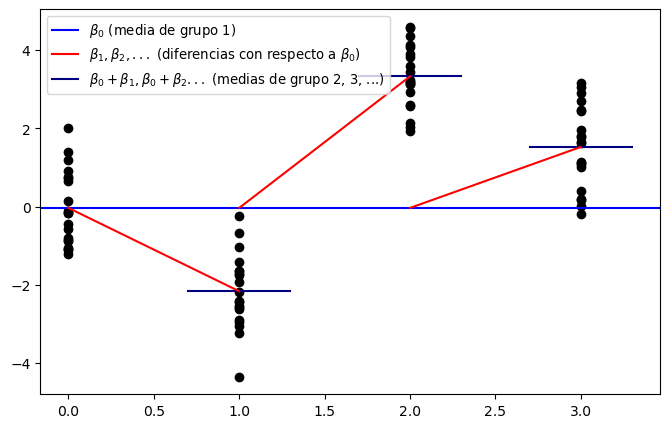

In [2]:
one_way_anova_plot(figsize=(8, 5))

### Ejemplo numérico

Supongamos que se quiere estudiar el efecto del tipo de fertilizante en la producción de maíz. Se toman muestras de maíz en tres tipos de fertilizantes: A, B y C. Para cada tipo de fertilizante se tomaron 20 muestras. En total, nuestra N total es 60. 



In [3]:
# set the seed
np.random.seed(123)
# number of points for each group
num_points = 20
# simulate data from 3 groups. The first argument is the mean, the second is the standard deviation
a = np.random.normal(15, 2, num_points)
b = np.random.normal(17, 2, num_points)
c = np.random.normal(13, 2, num_points)

df = pd.DataFrame()
df["y"] = np.concatenate([a, b, c])
# assign group names
df["group"] = list("".join([num_points * char for char in "abc"]))
# create dummy variables for each group. Note that we drop the first group,
# so that group a is the baseline. 
# The model is y = beta0 + beta1 * group_b + beta2 * group_c
df = df.join(pd.get_dummies(df.group, prefix="group", drop_first=True).astype(np.float64))
df.head()

,y,group,group_b,group_c
0,12.828739,a,0.0,0.0
1,16.994691,a,0.0,0.0
2,15.565957,a,0.0,0.0
3,11.987411,a,0.0,0.0
4,13.842799,a,0.0,0.0


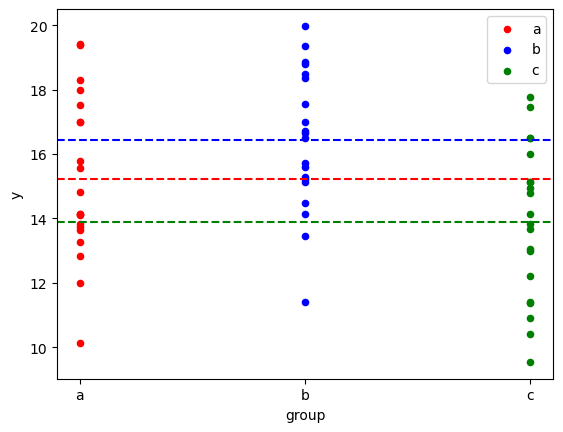

In [4]:
# plot de anova de una vía para a, b, c

colors = {'a': 'red', 'b': 'blue', 'c': 'green'}
fig, ax = plt.subplots()
for key, group in df.groupby('group'):
    # add the group data
    group.plot(ax=ax, kind='scatter', x='group', y='y', label=key, color=colors[key])
    # add the group mean
    plt.axhline(group.y.mean(), color=colors[key], linestyle='--')
plt.show()

F-statistic: 5.792, p-value: 5.1e-03


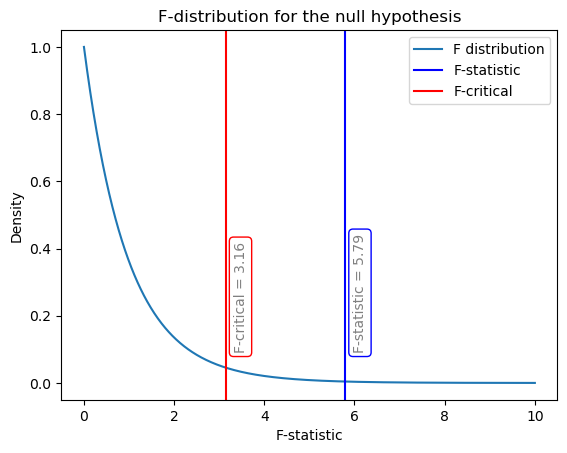

In [5]:
# fit the model using the formula notation
res = smf.ols("y ~ 1 + group_b + group_c", df).fit()
# Obtain the SST, SSG and SSW. MSE is the mean of the squared residuals, 
# also known as the residual variance
# MSE of each sum of squares is the sum of squares divided by the degrees of freedom.
# For SST the degrees of freedom is the number of points minus one. For each group  
# we have num_points, the the grand N is num_points * 3. 
SST = res.mse_total * (num_points * 3 - 1)
# The SSG degrees of freedom is the number of groups minus one.
SSG = res.mse_model * 2
# The SSW degrees of freedom is the number of points minus the number of groups.
SSW = res.mse_resid * (num_points * 3 - 3)

# the following is equivalent to the above
# SST = np.sum((df.y - df.y.mean()) ** 2)
# SSG = np.sum((df.y.mean() - df[["group_b", "group_c"]].dot(res.params[1:])) ** 2)
# SSW = SST - SSG

# calculate the F-statistic recomputing the MSG and MSW
MSG = SSG / 2
MSW = SSW / (num_points * 3 - 3)
F_stat = MSG / MSW

# note that the F-statistic is the same as the one obtained from the model using 
# F_stat = res.mse_mod el/ res.mse_resid

# Evaluate the p-value using the F distribution with 2 and 3 * num_points - 3 degrees of freedom
p_val = 1 - stats.f.cdf(F_stat, 2, 3 * num_points - 3)
# print the F-statistic and the p-value in scientific format
print("F-statistic: {:.3f}, p-value: {:.1e}".format(F_stat, p_val))

# plot the F distribution for the null and add the F_stat in blue and the F_critical at 5% in red.
# The null is that the groups have the same mean, so the F-statistic should be close to 1.
F_critical = stats.f.ppf(0.95, 2, 3 * num_points - 3)
F_quantiles = np.linspace(0, 10, 1000)
F_pdf = stats.f.pdf(F_quantiles, 2, 3 * num_points - 3)

plt.plot(F_quantiles, F_pdf, label="F distribution")
plt.axvline(F_stat, color="b", label="F-statistic")
plt.axvline(F_critical, color="r", label="F-critical")
plt.title("F-distribution for the null hypothesis")
plt.xlabel("F-statistic")
plt.ylabel("Density")
# annotate the text of the F-critical and F-statistic values vertically within bbox
plt.text(F_critical*1.05, 0.1, f'F-critical = {F_critical.round(2)}', 
         rotation=90, bbox=dict(facecolor='none', edgecolor='r',boxstyle='round'), alpha=0.5)
plt.text(F_stat*1.03, 0.1, f'F-statistic = {F_stat.round(2)}', 
         rotation=90, bbox=dict(facecolor='none', edgecolor='b',boxstyle='round'), alpha=0.5)
plt.legend()

In [6]:
# print the SST as the sum of SSG and SSW
print("SST: {:.3f}".format(SST))
print("SSG + SSW: {:.3f}".format(SSG + SSW))

SST: 383.954
SSG + SSW: 383.954


In [7]:
# los valores que regresa el modelo son los mismos que los que se calculan a mano.
# Imprimir res.fvalue, res.f_pvalue
res.fvalue

5.792086672196453

Si el F-stat es mayor que el F-critico, entonces rechazamos la hipótesis nula. En este caso, el F-stat es 5.79 y el F-critico es 3.16. Por lo tanto, rechazamos la hipótesis nula y aceptamos la hipótesis alternativa. Esto significa que hay una diferencia significativa entre los tipos de fertilizante. 

Notar que aún no sabemos cuál grupo es diferente. El análisis de varianza nos dice que hay una diferencia significativa entre los grupos, pero no nos dice cuál grupo es diferente.Para saberlo, se debe realizar un análisis de comparación de medias.

Para la comparación múltiple podemos usar el HSD (honest significant difference) de Tukey. Consiste en comparar cada grupo con el resto de los grupos. Si el p-valor, ajustado por el método de Tukey, es menor que el nivel de significancia, se rechaza la hipótesis nula y se acepta la hipótesis alternativa. Si el p-valor es mayor que el nivel de significancia, no se rechaza la hipótesis nula. El análisis de Tukey realiza un ajuste para las comparaciones múltiples de tal forma que mantenga el nivel de significancia global en el nivel de significancia elegido (e.g., 0.05).

Otra forma de probar las hipótesis es calcular el HSD de Tukey y compararlo con el HSD crítico. El HSD crítico se calcula con la siguiente fórmula:

$$\mathrm{HSD}_\text{critical value}=q_{\text{crit}}\sqrt{\frac{\mathrm{MSE}}{n}}$$

$$
\left|\overline{y}_{i}-\overline{y}_{j}\right|>\mathrm{HSD}_\text{critical value}
$$

En donde $\hat{y}_{i}$ es la media de las respuestas en el grupo $i$, $\hat{y}_{j}$ es la media de las respuestas en el grupo $j$, $n$ es el número réplicas por grupo, $MSE$ es el error cuadrático medio y $q_{\text{crit}}$ es el valor crítico de la distribución de rango estudentizada.

El $q_{\text{crit}}$ es el valor crítico de la distribución de rango estudentizada. Es difícil calcular manualmente el $q_{\text{crit}}$. Por lo tanto, se puede usar la tabla de Tukey para obtener el $q_{\text{crit}}$. 

In [8]:
# obtain the group means
df.groupby("group").y.mean()

group
a    15.228835
b    16.437643
c    13.892119
Name: y, dtype: float64

In [9]:
# obtain the group means by using the model
group_a_mean = res.params[0]
group_b_mean = res.params[0] + res.params[1]
group_c_mean = res.params[0] + res.params[2]
# print the group means
print("group a mean: {:.3f}".format(group_a_mean))
print("group b mean: {:.3f}".format(group_b_mean))
print("group c mean: {:.3f}".format(group_c_mean))

group a mean: 15.229
group b mean: 16.438
group c mean: 13.892


In [10]:
# multiple comparison test using Tukey's HSD
import statsmodels.stats.multicomp as multi
tukey = multi.pairwise_tukeyhsd(df.y, df.group, alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
a,b,1.2088,0.2474,-0.5917,3.0093,False
a,c,-1.3367,0.1832,-3.1372,0.4638,False
b,c,-2.5455,0.0035,-4.346,-0.745,True


In [11]:
# the critical hsd is
hsd = tukey.q_crit * np.sqrt(res.mse_resid / num_points)
hsd

1.8005222230290598

In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     5.792
Date:                Mon, 13 Nov 2023   Prob (F-statistic):            0.00513
Time:                        12:09:29   Log-Likelihood:                -135.27
No. Observations:                  60   AIC:                             276.5
Df Residuals:                      57   BIC:                             282.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.2288      0.529     28.784      0.000      14.169      16.288
group_b        1.2088      0.748      1.616      0.112      -0.289       2.707
group_c       -1.3367      0.748     -1.787      0.079      -2.835       0.162
==============================================================================
Omnibus:                        1.813   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.306
Skew:                          -0.110   Prob(JB):                        0.520
Kurtosis:                       2.311   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Otro ejemplo numerico

In [13]:
import pandas as pd

datos = pd.DataFrame({
    'Control': [21, 19.5, 22.5, 21.5, 20.5, 21],
    'F1': [32, 30.5, 25, 27.5, 28, 28.6],
    'F2': [22.5, 26, 28, 27, 26.5, 25.2],
    'F3': [28, 27.5, 31, 29.5, 30, 29.2]
})

datos

,Control,F1,F2,F3
0,21.0,32.0,22.5,28.0
1,19.5,30.5,26.0,27.5
2,22.5,25.0,28.0,31.0
3,21.5,27.5,27.0,29.5
4,20.5,28.0,26.5,30.0
5,21.0,28.6,25.2,29.2


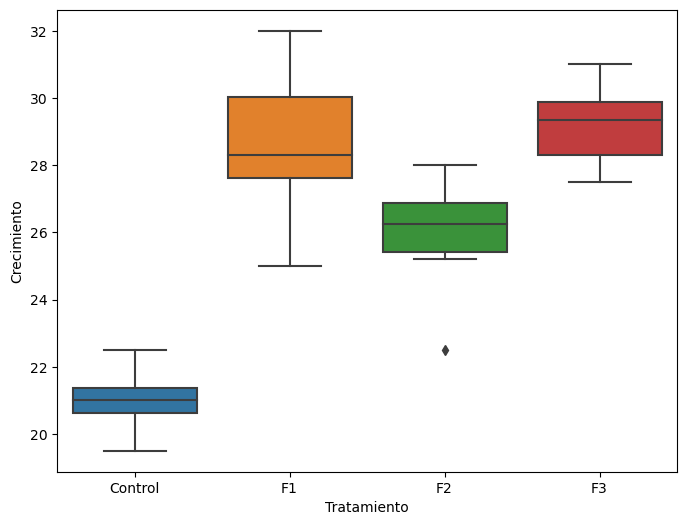

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert from wide to long (tidy)
datos_long = datos.melt(var_name='Tratamiento', value_name='Crecimiento')

# Visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tratamiento', y='Crecimiento', data=datos_long)
plt.show()

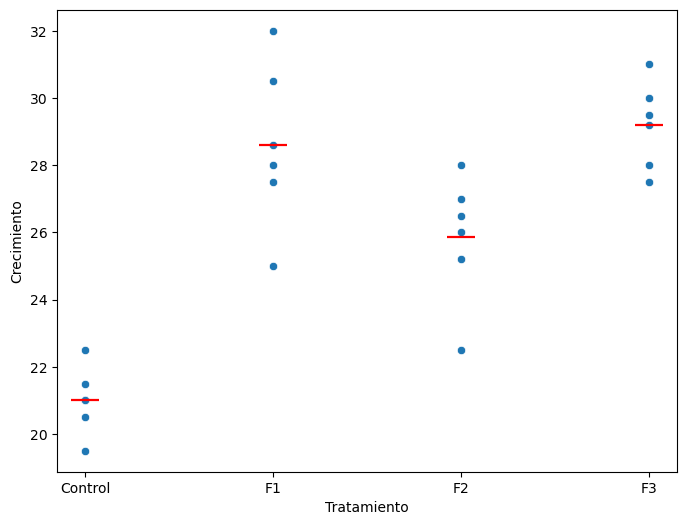

In [28]:
# Calculate column means
col_means = datos.mean().reset_index()
col_means.columns = ['Tratamiento', 'Crecimiento']

# Calculate group statistics
group_stats = datos_long.groupby('Tratamiento')['Crecimiento'].agg(['mean', 'count', 'median', lambda x: x.quantile(0.75) - x.quantile(0.25)]).reset_index()
group_stats.columns = ['Tratamiento', 'media_trat', 'cantidad', 'mediana', 'rango_iq']

# Visualization of variability
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Tratamiento', y='Crecimiento', data=datos_long)
# plt.axhline(y=datos_long['Crecimiento'].mean(), color='red')

# Add group means
sns.scatterplot(x='Tratamiento', y='media_trat', data=group_stats, color='red', s=400, marker='_')
plt.show()

In [16]:
import statsmodels.formula.api as smf

# Calculate the test statistic
# First, we run a linear regression model, and then we compare the results
anv = smf.ols('Crecimiento ~ Tratamiento', data=datos_long).fit()
print(anv.summary())

                            OLS Regression Results                            
Dep. Variable:            Crecimiento   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     27.46
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           2.71e-07
Time:                        12:09:31   Log-Likelihood:                -45.255
No. Observations:                  24   AIC:                             98.51
Df Residuals:                      20   BIC:                             103.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            21.0000      0.71

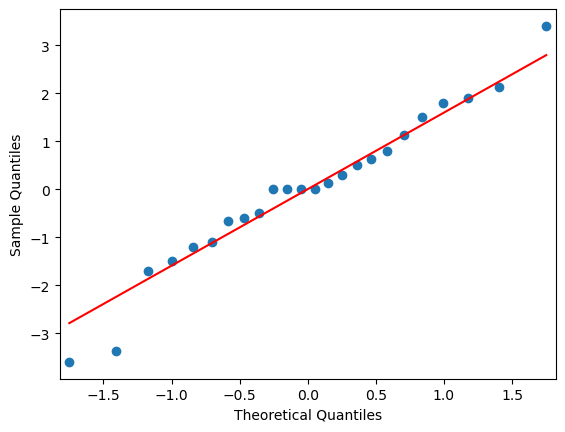

In [34]:
# Q-Q plot para los residuos del modelo ANOVA
res = anv.resid
fig = sm.qqplot(res, line='s')  # 's' indica una línea de referencia ajustada a la muestra
# Mostrar el gráfico
plt.show()

In [33]:
# Pruebas para las suposiciones de ANOVA
# Normalidad de los residuos usando la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(anv.resid)
# Homogeneidad de varianzas usando la prueba de Levene

levene_test = stats.levene(datos_long['Crecimiento'][datos_long['Tratamiento'] == 'Control'],
                           datos_long['Crecimiento'][datos_long['Tratamiento'] == 'F1'],
                           datos_long['Crecimiento'][datos_long['Tratamiento'] == 'F2'],
                           datos_long['Crecimiento'][datos_long['Tratamiento'] == 'F3'])

# Resultados

shapiro_test, levene_test

(ShapiroResult(statistic=0.9732214212417603, pvalue=0.7464066743850708),
 LeveneResult(statistic=1.0491159135559924, pvalue=0.3926038372880547))

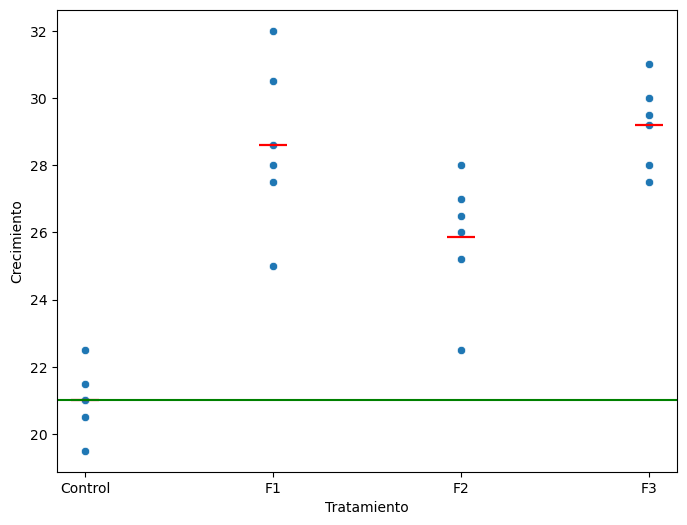

In [29]:
# Visualization with group means and intercept
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Tratamiento', y='Crecimiento', data=datos_long)
# plt.axhline(y=datos_long['Crecimiento'].mean(), color='red')
# el intercepto
plt.axhline(y=21, color='green')

# Add group means
sns.scatterplot(x='Tratamiento', y='media_trat', data=group_stats, color='red', s=400, marker='_')
plt.show()

In [18]:
# desempaquetar los coeficientes
intercepto, beta1, beta2, beta3 = anv.params
# imprimir los coeficientes

print("Intercepto: {:.3f}".format(intercepto))
print("beta1: {:.3f}".format(beta1))
print("beta2: {:.3f}".format(beta2))
print("beta3: {:.3f}".format(beta3))


Intercepto: 21.000
beta1: 7.600
beta2: 4.867
beta3: 8.200


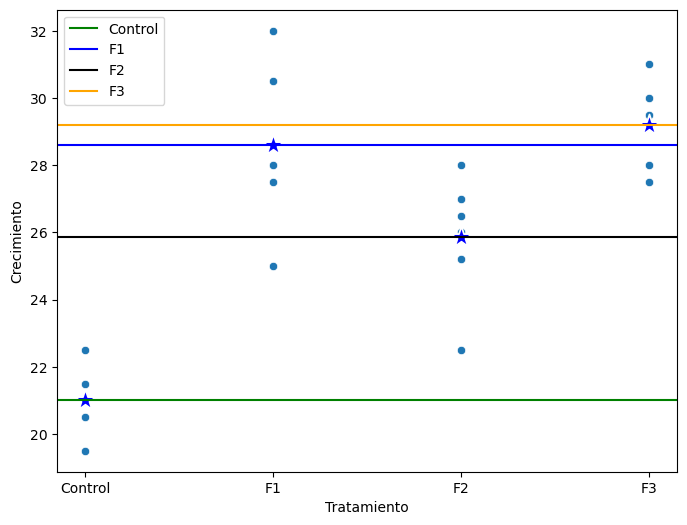

In [30]:
# el efecto del Control!
# ¿cuál es el efecto de F1, F2 y F3?

f1 = beta1 + intercepto
f2 = beta2 + intercepto
f3 = beta3 + intercepto

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Tratamiento', y='Crecimiento', data=datos_long)
# plt.axhline(y=datos_long['Crecimiento'].mean(), color='red')
# el intercepto
plt.axhline(y=21, color='green', label='Control')
# los efectos de los tratamientos, en diferente color
plt.axhline(y=f1, color='blue', label='F1')
plt.axhline(y=f2, color='black', label='F2')
plt.axhline(y=f3, color='orange', label='F3')
sns.scatterplot(x='Tratamiento', y='media_trat', data=group_stats, color='blue', s=250, marker='*')
plt.legend()
plt.show()


In [20]:
import statsmodels.api as sm
from scipy.stats import f

# Calculate the sum of squares
anova_table = sm.stats.anova_lm(anv, typ=2)

# Calculate the total sum of squares
tss = ((datos_long['Crecimiento'] - datos_long['Crecimiento'].mean())**2).sum()

# Calculate the treatment sum of squares
group_means = datos_long.groupby('Tratamiento')['Crecimiento'].mean()
tr_ss = ((group_means - datos_long['Crecimiento'].mean())**2 * datos_long['Tratamiento'].value_counts()).sum()

# Calculate the residual sum of squares
res_ss = tss - tr_ss

# Calculate the degrees of freedom
N = len(datos_long)
df_tss = N - 1
df_trat = len(datos_long['Tratamiento'].unique()) - 1
df_res = df_tss - df_trat

# Calculate the explained and unexplained variance
var_exp = tr_ss / df_trat
var_no_exp = res_ss / df_res

# Calculate the F statistic
F_obs = var_exp / var_no_exp

F_obs

27.46477334789728

In [21]:
# Calculate the critical F value
alfa = 0.05  # assuming a significance level of 0.05
F_crit = f.ppf(1 - alfa, df_trat, df_res)
F_crit

3.09839121214078

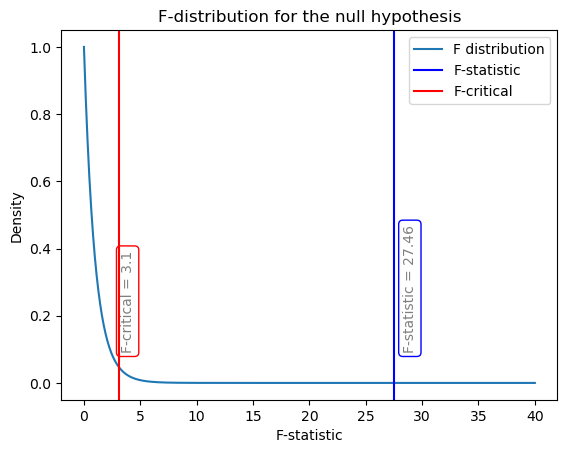

In [22]:
F_quantiles = np.linspace(0, 40, 1000)
num_points = len(datos_long)
F_pdf = f.pdf(F_quantiles, 2, 3 * num_points - 3)

plt.plot(F_quantiles, F_pdf, label="F distribution")
plt.axvline(F_obs, color="b", label="F-statistic")
plt.axvline(F_crit, color="r", label="F-critical")
plt.title("F-distribution for the null hypothesis")
plt.xlabel("F-statistic")
plt.ylabel("Density")
# annotate the text of the F-critical and F-statistic values vertically within bbox
plt.text(F_crit*1.05, 0.1, f'F-critical = {F_crit.round(2)}', 
         rotation=90, bbox=dict(facecolor='none', edgecolor='r',boxstyle='round'), alpha=0.5)
plt.text(F_obs*1.03, 0.1, f'F-statistic = {F_obs.round(2)}', 
         rotation=90, bbox=dict(facecolor='none', edgecolor='b',boxstyle='round'), alpha=0.5)
plt.legend()

In [23]:
# Decision rule
decision = 'Reject H0' if F_obs > F_crit else 'Accept H0'
print(decision)

# Calculate the p-value
p_val = f.sf(F_obs, df_trat, df_res)

# Decision rule based on p-value
decision_p = 'Reject H0' if p_val < alfa else 'Accept H0'
print(decision_p)

Reject H0
Reject H0


7.599999999999998 1.4876460576841712


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Control     F1      7.6    0.0  4.7771 10.4229   True
Control     F2   4.8667 0.0006  2.0437  7.6896   True
Control     F3      8.2    0.0  5.3771 11.0229   True
     F1     F2  -2.7333 0.0599 -5.5563  0.0896  False
     F1     F3      0.6 0.9324 -2.2229  3.4229  False
     F2     F3   3.3333 0.0171  0.5104  6.1563   True
-----------------------------------------------------


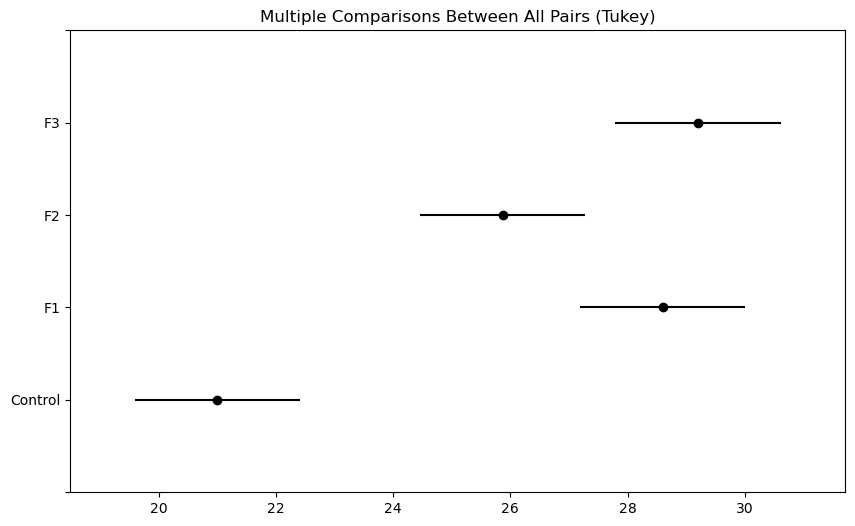

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import t

# Calculate the Tukey statistic
q = t.ppf(1 - 0.05 / 2, df_res)
w = q * ((res_ss / df_res) / 6)**0.5

# Calculate the mean of F1 and Control
mean_f1 = group_stats.loc[group_stats['Tratamiento'] == 'F1', 'media_trat'].values[0]
mean_control = group_stats.loc[group_stats['Tratamiento'] == 'Control', 'media_trat'].values[0]

# Calculate the difference of means
diff_means = mean_f1 - mean_control

print(diff_means, w)

# The difference is significant if diff_means > w

# Perform Tukey's HSD test for all possible mean differences
tukey = pairwise_tukeyhsd(endog=datos_long['Crecimiento'], groups=datos_long['Tratamiento'], alpha=0.05)
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.show()

## 4.2. MANOVA

## 4.3. ANCOVA